In [31]:
import json
import numpy as np
import pandas as pd
from pathlib import Path


# mvr meaning mean-to-variance-ratio
def compute_sliding_window_stats(values, window_size):
    mvr_list = []
    n = len(values)

    for start in range(n - window_size + 1):
        window = values[start:start + window_size]

        mean = np.mean(window)
        variance = np.var(window)  # Sample variance (ddof=1)

        if variance != 0:
            mvr = mean / variance
        else:
            mvr = float('inf')  # Handle cases with zero variance

        mvr_list.append({'mean': mean, 'variance': variance, 'mvr': mvr})

    return mvr_list


def compute_sliding_window_derivative(steps, values, window_size):
    derivative_list = []
    n = len(values)

    for start in range(n - window_size + 1):
        start_value = values[start]
        end_value = values[start + window_size - 1]
        start_step = steps[start]
        end_step = steps[start + window_size - 1]

        delta_value = end_value - start_value
        delta_step = end_step - start_step

        derivative = delta_value / delta_step if delta_step != 0 else float('inf')

        derivative_list.append(derivative)

    return derivative_list


def compute_learning_results(data, window_size):
    stats = compute_sliding_window_stats(data['Value'], window_size)
    variances = [stat['variance'] for stat in stats]
    means = [stat['mean'] for stat in stats]
    mvrs = [stat['mvr'] for stat in stats]
    rates = compute_sliding_window_derivative(data['Step'], data['Value'], window_size)

    return {
        "variance": {'mean': '{:0.2e}'.format(np.mean(variances)), 'distribution': variances},
        "mean": {'mean': '{:0.2e}'.format(np.mean(means)), 'distribution': means},
        "mvr": {'mean': '{:0.2e}'.format(np.mean(mvrs)), 'distribution': mvrs},
        "rate": {'mean': '{:0.2e}'.format(np.mean(rates)), 'distribution': rates},
        "final reward": {'mean' : int(data['Value'][99]), 'distribution': data['Value'][99]}
    }

def get_learning_data(agent_name: str) -> str:
    return pd.read_csv(Path().joinpath('data_paper', agent_name))[['Step', 'Value']]


WINDOW_SIZE = 10

agents_data = {
    "B(80,0.5)": get_learning_data('scratch_s80_f0.5_1.csv'),
    "S(80,1) -> T(80,0.5)": get_learning_data('transs80f1_s80_f0.5_0_1.csv'),
    "B(50,0.5)": get_learning_data('scratch_s50_f0.5_1.csv'),
    "S(50,1) -> T(50,0.5)": get_learning_data('transs50f1_s50_f0.5_1_1.csv'),
    "B(80,1)": get_learning_data('scratch_s80_f1_1.csv'),
    "S(50,1) -> T(80,1)": get_learning_data('transs50f1_s80_f1_1_1.csv'),
    "S(50,0.5) -> T(80,0.5)": get_learning_data('transs50f0.5_s80_f0.5_1_1.csv'),
}

learning_results = {}
for agent, data in agents_data.items():
    learning_results[agent] = compute_learning_results(data, WINDOW_SIZE)

output_file = Path().joinpath('data_paper', 'training_calculations_output.json')

with open(output_file, "w") as json_file:
    json.dump(learning_results, json_file, indent=4)

for agent, data in learning_results.items():
    row = [agent]
    for metric, values in data.items():
        row.append(f'{metric} {values["mean"]}')
    print(' | '.join(row))
    print('-' * len(row))


B(80,0.5) | variance 2.65e+05 | mean -8.43e+03 | mvr -5.89e-01 | rate 9.51e-03 | final reward -6694
------
S(80,1) -> T(80,0.5) | variance 1.75e+04 | mean -5.15e+03 | mvr -3.08e+00 | rate 1.16e-03 | final reward -4599
------
B(50,0.5) | variance 3.03e+05 | mean -9.25e+03 | mvr -7.42e-01 | rate 7.63e-03 | final reward -8513
------
S(50,1) -> T(50,0.5) | variance 3.58e+09 | mean -4.52e+04 | mvr -9.50e-01 | rate 5.54e-01 | final reward -5795
------
B(80,1) | variance 2.75e+05 | mean -8.78e+03 | mvr -5.95e-01 | rate 6.55e-03 | final reward -8524
------
S(50,1) -> T(80,1) | variance 5.38e+10 | mean -2.19e+05 | mvr -7.74e-01 | rate 2.66e+00 | final reward -6839
------
S(50,0.5) -> T(80,0.5) | variance 6.87e+03 | mean -5.06e+03 | mvr -2.44e+00 | rate 3.29e-04 | final reward -5291
------


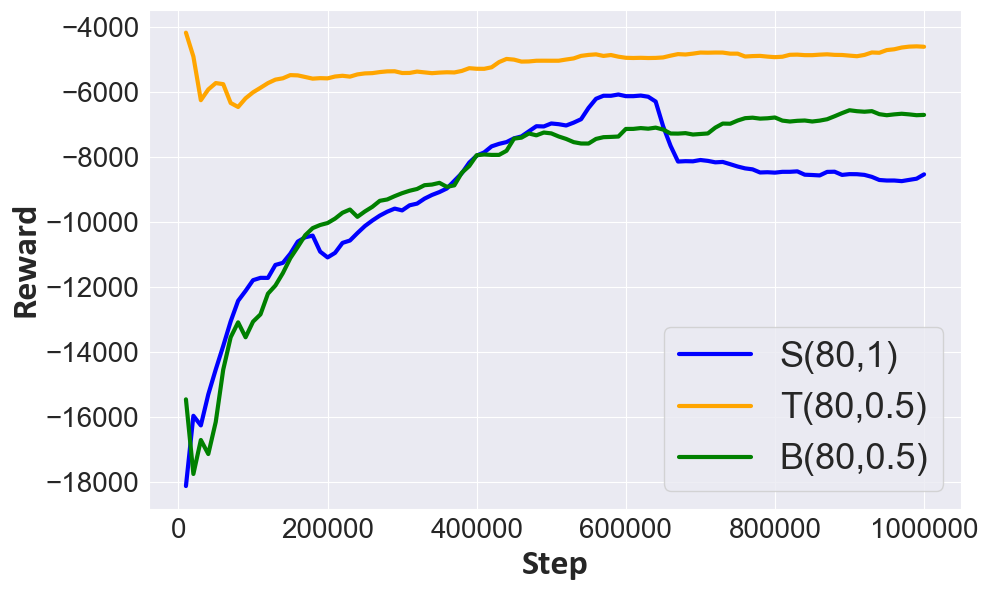

In [16]:
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

from_agent = Path().joinpath('data_paper', 'scratch_s80_f1_1.csv')
to_agent = Path().joinpath('data_paper', 'transs80f1_s80_f0.5_0_1.csv')
baseline_agent = Path().joinpath('data_paper', 'scratch_s80_f0.5_1.csv')

from_data = pd.read_csv(from_agent)[['Step', 'Value']]
to_data = pd.read_csv(to_agent)[['Step', 'Value']]
baseline_data = pd.read_csv(baseline_agent)[['Step', 'Value']]

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot both datasets
sns.lineplot(data=from_data, x='Step', y='Value', label='S(80,1)', color='blue', linewidth=3)
sns.lineplot(data=to_data, x='Step', y='Value', label='T(80,0.5)', color='orange', linewidth=3)
sns.lineplot(data=baseline_data, x='Step', y='Value', label='B(80,0.5)', color='green', linewidth=3)

# Adding titles and labels
plt.xlabel('Step', fontsize=26, weight='bold', font='Calibri')
plt.ylabel('Reward', fontsize=26, weight='bold', font='Calibri')
plt.tick_params(labelsize=20)
plt.ticklabel_format(style='plain', axis='x')

# Display the legend
plt.legend()
plt.legend(prop={'size': 26})

# Show the plot
plt.tight_layout()
plt.show()